<a href="https://colab.research.google.com/github/singhnidh/AgriGuard-A-Smart-Leaf-Disease-Detection-System-Leveraging-Attention-Mechanism-and-Ensemble-Learning/blob/main/Model_2_InceptionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Conv2D, multiply, Activation, concatenate, Reshape
from keras.optimizers import Adam
from google.colab import drive
drive.mount('/content/drive')
import os
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Attention
from keras.optimizers import Adam
!pip install livelossplot
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from livelossplot.inputs.keras import PlotLossesCallback
plot_loss_1 = PlotLossesCallback()
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalAveragePooling2D, MaxPooling2D, concatenate, Activation, multiply, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing import image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BATCH_SIZE = 64
input_shape = (224, 224, 3)
n_classes = 20

#------------------------------------------>>>>>>>  Data generators <<<<<<<<<<-------------------------------------#

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input)  # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)  # VGG16 preprocessing
download_dir = '/content/drive/MyDrive/ VIT_MT_PROJECT__2/ DATASET'

train_data_dir ='/content/drive/MyDrive/ VIT_MT_PROJECT__2/ DATASET/ Train_data'
test_data_dir = '/content/drive/MyDrive/ VIT_MT_PROJECT__2/ DATASET/Test_data'

class_subset = os.listdir('/content/drive/MyDrive/ VIT_MT_PROJECT__2/ DATASET/ Train_data')


traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)



Found 20508 images belonging to 20 classes.
Found 3608 images belonging to 20 classes.
Found 5806 images belonging to 20 classes.


In [ ]:
#---------------------------------->>>>>>>  custom attention module <<<<<<<<<<------------------------------------#

def attention_module(x, g):
    theta_x = Conv2D(filters=int(x.shape[-1]), kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    phi_g = Dense(units=int(g.shape[-1]), activation='relu')(g)

    # Use a 1x1 convolutional layer on phi_g to maintain spatial dimensions
    conv_phi_g = Conv2D(filters=int(g.shape[-1]), kernel_size=(1, 1), strides=(1, 1), padding='same')(phi_g)

    # Reshape conv_phi_g to match spatial dimensions of theta_x
    #reshaped_phi_g = Reshape(target_shape=(5, 5, int(g.shape[-1])))(conv_phi_g)
    reshaped_phi_g = Reshape(target_shape=(5, 5, int(g.shape[-1])))(conv_phi_g)
    # Concatenate theta_x and reshaped_phi_g along the channels axis
    concat_xg = concatenate([theta_x, reshaped_phi_g], axis=-1)
    f = Activation('relu')(concat_xg)

    # Apply convolutional layer and activation to calculate attention weights
    psi_f = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='sigmoid')(f)

    # Multiply input feature map with attention weights
    att_x = multiply([x, psi_f])
    return att_x

def inceptionv3_attention(input_shape, n_classes, optimizer='adam'):
    # Load InceptionV3 base model without top layers
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Define input layer
    input_tensor = Input(shape=input_shape)

    # Apply attention mechanism to selected layers of the base model
    x = base_model(input_tensor)
    att_x = attention_module(x, x)

    # Global average pooling and dense layer for classification
    x = GlobalAveragePooling2D()(att_x)
    x = Dense(1024, activation='relu')(x)
    output_tensor = Dense(n_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=input_tensor, outputs=output_tensor)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Instantiate the model

optimizer = Adam(learning_rate=0.0001)
n_epochs = 10 # Set your desired batch size
n_steps = 50 #traingen.samples // BATCH_SIZE
n_val_steps = 50 #validgen.samples // BATCH_SIZE

inceptionv3_with_attention = inceptionv3_attention(input_shape, n_classes)

# Print model summary
inceptionv3_with_attention.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 inception_v3 (Functional)   (None, 5, 5, 2048)           2180278   ['input_2[0][0]']             
                                                          4                                       
                                                                                                  
 dense (Dense)               (None, 5, 5, 2048)           4196352   ['inception_v3[0][0]']        
                                                                                                  
 conv2d_95 (Conv2D)          

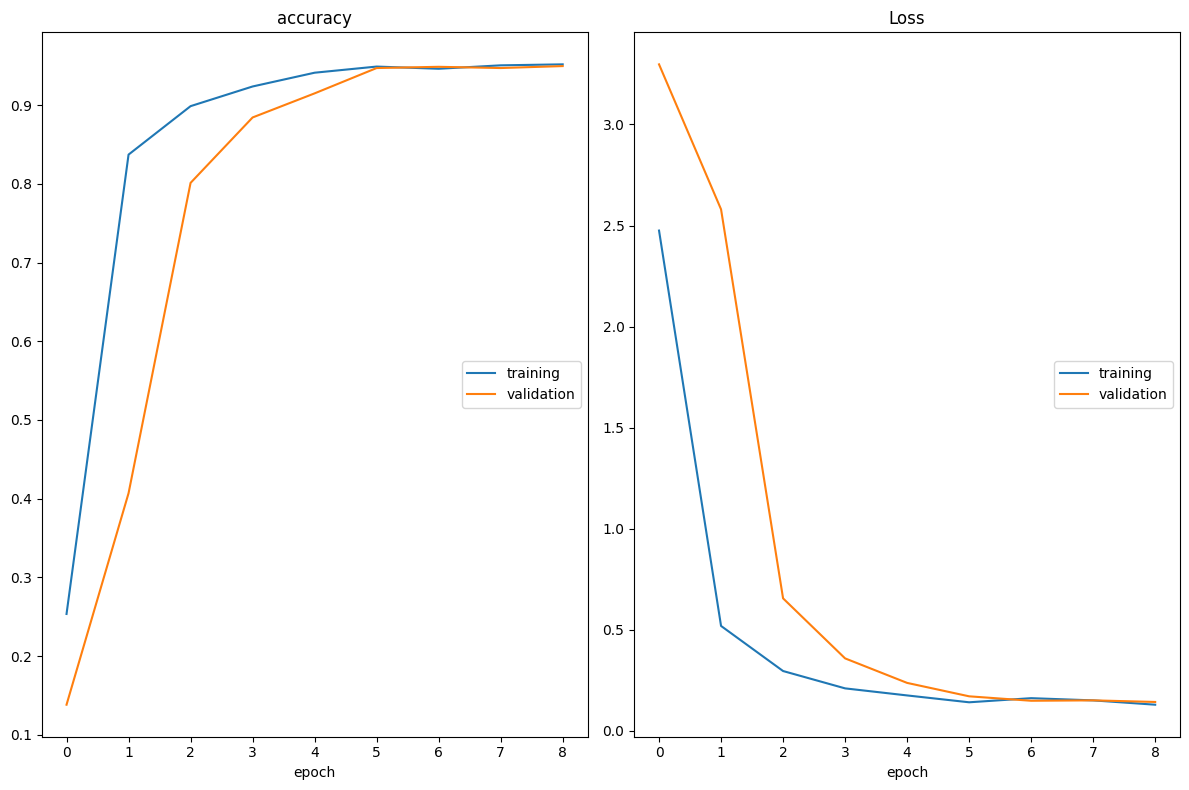

accuracy
	training         	 (min:    0.253, max:    0.952, cur:    0.952)
	validation       	 (min:    0.138, max:    0.950, cur:    0.950)
Loss
	training         	 (min:    0.130, max:    2.475, cur:    0.130)
	validation       	 (min:    0.144, max:    3.297, cur:    0.144)
50/50 [==============================] - 2433s 49s/step - loss: 0.1300 - accuracy: 0.9519 - val_loss: 0.1436 - val_accuracy: 0.9497
Epoch 10/10
 8/50 [===>..........................] - ETA: 27:08 - loss: 0.1719 - accuracy: 0.9434

In [ ]:

# Compile the model

inceptionv3_with_attention.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint

# Define filepath for saving the best weights
checkpoint_filepath = "/content/drive/MyDrive/ VIT_MT_PROJECT__2/MODEL NOTEBOOK/Trained Model weight saved/inceptionv3_attention_best_weights.h5"

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,  # Save only the best model based on validation loss
    monitor='val_loss',   # Monitor validation loss
    mode='min',           # Minimize the validation loss
    verbose=1             # Show progress
)

early_stop_custom = EarlyStopping(monitor='val_loss',
                                   patience=10,
                                   restore_best_weights=True,
                                   mode='min')


# Train the model with ModelCheckpoint callback
model_1_inception = inceptionv3_with_attention.fit(
    traingen,
    batch_size=BATCH_SIZE,
    epochs=n_epochs,
    validation_data=validgen,
    steps_per_epoch=n_steps,
    validation_steps=n_val_steps,
    callbacks=[checkpoint_callback, early_stop_custom, PlotLossesCallback()],  # Pass the ModelCheckpoint callback
    verbose=1
)

#------------------------------------------->>>>>>>Saving the model <<<<<<<<<<----------------------------#
#------------------------------------------->>>>>>># Saving the model<<<<<<<<<<----------------------------#

filepath_with_attention_custom = "/content/drive/MyDrive/ VIT_MT_PROJECT__2/MODEL NOTEBOOK/Trained Model weight saved/model_2_inception.h5"
inceptionv3_with_attention.save(filepath_with_attention_custom)


#**Continue training model from epoch after intrrupted**#

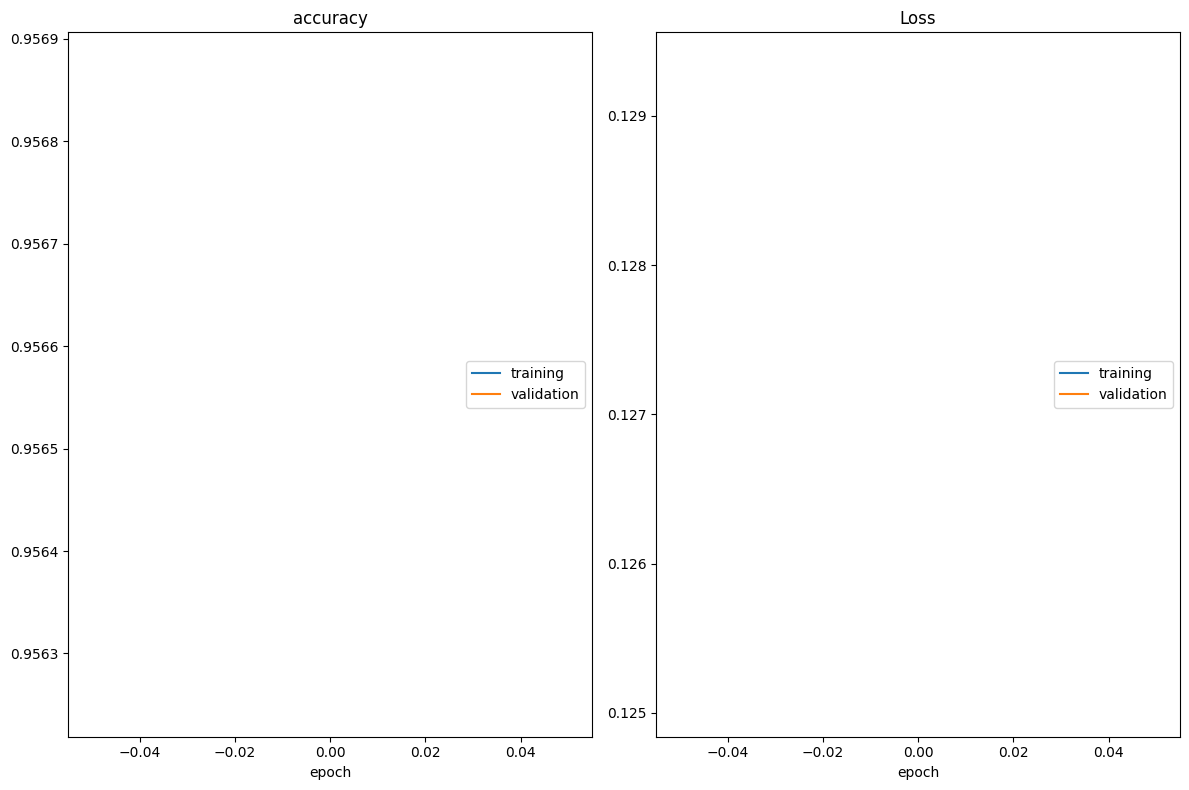

accuracy
	training         	 (min:    0.957, max:    0.957, cur:    0.957)
	validation       	 (min:    0.956, max:    0.956, cur:    0.956)
Loss
	training         	 (min:    0.129, max:    0.129, cur:    0.129)
	validation       	 (min:    0.125, max:    0.125, cur:    0.125)
50/50 [==============================] - 3384s 67s/step - loss: 0.1293 - accuracy: 0.9569 - val_loss: 0.1251 - val_accuracy: 0.9563


In [ ]:
from keras.callbacks import ModelCheckpoint
optimizer = Adam(learning_rate=0.0001)
n_epochs = 10 # Set your desired batch size
n_steps = 50 #traingen.samples // BATCH_SIZE
n_val_steps = 50 #validgen.samples // BATCH_SIZE
remaining_epochs= n_epochs - 9

# Define filepath for saving the best weights
checkpoint_filepath = "/content/drive/MyDrive/ VIT_MT_PROJECT__2/MODEL NOTEBOOK/Trained Model weight saved/inceptionv3_attention_best_weights.h5"

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,  # Save only the best model based on validation loss
    monitor='val_loss',   # Monitor validation loss
    mode='min',           # Minimize the validation loss
    verbose=1             # Show progress
)

early_stop_custom = EarlyStopping(monitor='val_loss',
                                   patience=10,
                                   restore_best_weights=True,
                                   mode='min')


# continue Train the model with ModelCheckpoint callback
from keras.models import load_model

# Load the model with the best weights
inceptionv3_with_attention = load_model(checkpoint_filepath)

# Continue training the model if needed
model_1_inception = inceptionv3_with_attention.fit(
    traingen,
    batch_size=BATCH_SIZE,
    epochs=remaining_epochs,  # Define the remaining number of epochs to train
    validation_data=validgen,
    steps_per_epoch=n_steps,
    validation_steps=n_val_steps,
    callbacks=[checkpoint_callback, early_stop_custom, PlotLossesCallback()],
    verbose=1
)

#------------------------------------------->>>>>>>Saving the model <<<<<<<<<<----------------------------#
#------------------------------------------->>>>>>># Saving the model<<<<<<<<<<----------------------------#

filepath_with_attention_custom = "/content/drive/MyDrive/ VIT_MT_PROJECT__2/MODEL NOTEBOOK/Trained Model weight saved/model_2_inception.h5"
inceptionv3_with_attention.save(filepath_with_attention_custom)

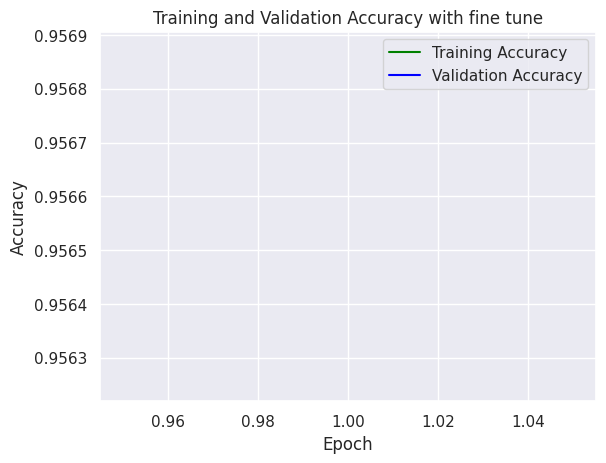

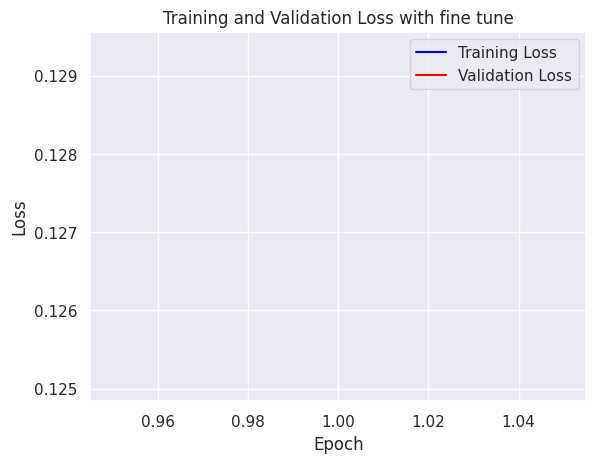

In [ ]:
#------------------------------------------->>>>>>>Plot training and validation graph<<<<<<<<<<----------------------------#
#------------------------------------------->>>>>>> Plot training and validation graph<<<<<<<<<<----------------------------#
sns.set()
acc = model_1_inception.history['accuracy']
val_acc = model_1_inception.history['val_accuracy']
loss = model_1_inception.history['loss']
val_loss = model_1_inception.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy with fine tune')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss with fine tune')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from keras.models import load_model
import numpy as np
model_1_inception = load_model('/content/drive/MyDrive/ VIT_MT_PROJECT__2/MODEL NOTEBOOK/Trained Model weight saved/model_2_inception.h5')

In [ ]:
#------------------------------------------->>>>>>>Calculate model test accuracy <<<<<<<<<<----------------------------#
#------------------------------------------->>>>>>>Testing and Evaluation<<<<<<<<<<------------------------------------#
inception_preds_attention_custom = model_1_inception.predict(testgen)
inception_pred_classes_attention_custom = np.argmax(inception_preds_attention_custom, axis=1)

5806/5806 [==============================] - 1300s 222ms/step


In [ ]:
true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v, k) for k, v in class_indices.items())
inception_acc_attention_custom = accuracy_score(true_classes, inception_pred_classes_attention_custom)
print("INCEPTION Model Accuracy with Custom Attention Mechanism: {:.2f}%".format(inception_acc_attention_custom * 100))

INCEPTION Model Accuracy with Custom Attention Mechanism: 92.99%


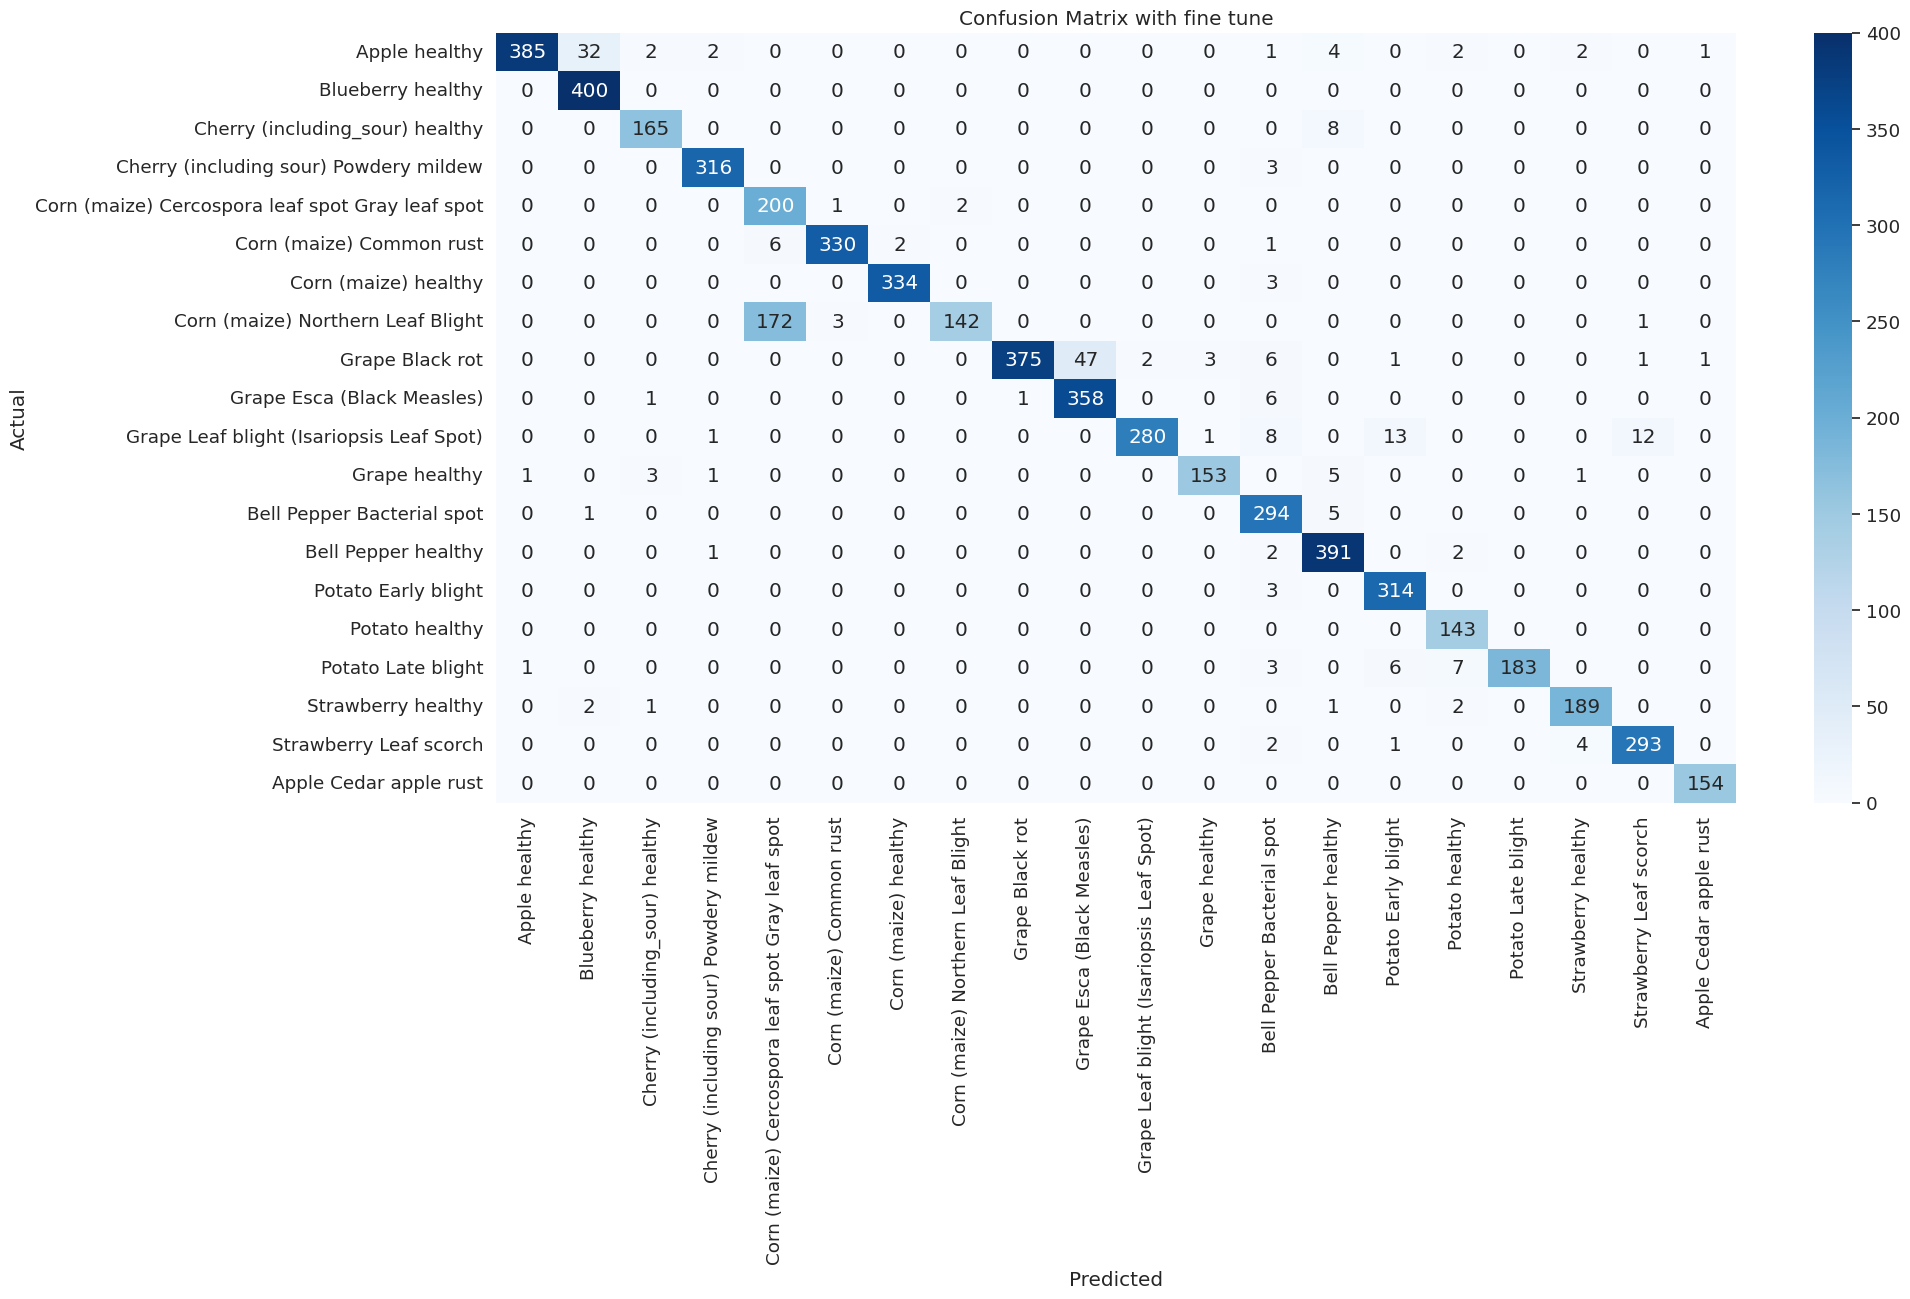

In [ ]:
#------------------------------------------->>>>>>>Draw confusion metrics <<<<<<<<<<----------------------------#
#------------------------------------------->>>>>>>Draw confusion metrics<<<<<<<<<<----------------------------#
# Confusion Matrix, Accuracy, F1 Score, Precision, Recall after fine-tuning

cm = confusion_matrix(true_classes, inception_pred_classes_attention_custom)
# Define class names if you have them
class_names = testgen.class_indices.keys()

# Create a heatmap
plt.figure(figsize=(20,10))
sns.set(font_scale=1.2)  # Adjust the font size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with fine tune')
plt.show()

In [ ]:
#------------------------------------------->>>>>>>Calculate metrics classification report<<<<<<<<<<----------------------------#
#------------------------------------------->>>>>>> Calculate metrics classification report<<<<<<<<<<----------------------------#

# Calculate metrics
cm = confusion_matrix(true_classes, inception_pred_classes_attention_custom)
classification_rep = classification_report(true_classes, inception_pred_classes_attention_custom)
precision = precision_score(true_classes, inception_pred_classes_attention_custom, average='weighted',zero_division=True)
recall = recall_score(true_classes, inception_pred_classes_attention_custom, average='weighted',zero_division=True)
f1 = f1_score(true_classes, inception_pred_classes_attention_custom, average='weighted',zero_division=True)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Display classification report, precision, recall, and F1 score
print("\nClassification Report:")
print(classification_rep)
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

Confusion Matrix:
[[385  32   2   2   0   0   0   0   0   0   0   0   1   4   0   2   0   2
    0   1]
 [  0 400   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0 165   0   0   0   0   0   0   0   0   0   0   8   0   0   0   0
    0   0]
 [  0   0   0 316   0   0   0   0   0   0   0   0   3   0   0   0   0   0
    0   0]
 [  0   0   0   0 200   1   0   2   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   6 330   2   0   0   0   0   0   1   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0 334   0   0   0   0   0   3   0   0   0   0   0
    0   0]
 [  0   0   0   0 172   3   0 142   0   0   0   0   0   0   0   0   0   0
    1   0]
 [  0   0   0   0   0   0   0   0 375  47   2   3   6   0   1   0   0   0
    1   1]
 [  0   0   1   0   0   0   0   0   1 358   0   0   6   0   0   0   0   0
    0   0]
 [  0   0   0   1   0   0   0   0   0   0 280   1   8   0  13   0   0   0
   12   0]
 [  1   0   3   1   0   0   0   0   0   0   0 1

1/1 [==============================] - 0s 208ms/step


Text(0.5, 1.0, 'predicted: 0')

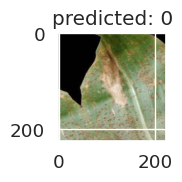

In [ ]:
#------------------------------------------->>>>>>>Pridict Image class<<<<<<<<<<----------------------------#
#------------------------------------------->>>>>>>Pridict Image class<<<<<<<<<<----------------------------#

# Load an image from file
img_path = '/content/drive/MyDrive/ VIT_MT_PROJECT__2/ DATASET/Test_data/Corn (maize) Common rust/aug_1001_3545.jpg'
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra dimension and preprocess the image
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
i=1
# Make the prediction
predictions = model_1_inception.predict(img_array)
#print(predictions)
predicted = inception_pred_classes_attention_custom[np.argmax(predictions)]
plt.subplot(240+1+i)
plt.imshow(img)
plt.title('predicted: ' + str(predicted))
# Decode and print the top-3 predicted classes
#decoded_predictions = decode_predictions(predictions, top=3)
#print(decoded_predictions)
